# 강화 학습 (Reinforcement learning) 3

In [5]:
import random 
import math 

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F
from collections import deque 

import gymnasium as gym 

## Vanilla DQN : Carte-Pole

In [7]:
# 하이퍼파라미터
eposides = 100    
e_start = 0.9  
e_end = 0.05  
e_decay = 200  
gamma = 0.8      
lr = 0.001       
batch_size = 64  

In [8]:
class DQN_Cart(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

        self.optimizer = optim.Adam(self.model.parameters(), lr = lr)
        self.step = 0
        self.deque = deque(maxlen=1000)


    def memorize(self, state, action, reward, next_state):
        self.deque.append((state, 
                            action, 
                            torch.FloatTensor([reward]), 
                            torch.FloatTensor([next_state])))
        
    def action(self, state):
        eps_theta = e_end + (e_start - e_end)*np.exp(-(self.step/e_decay))
        self.step += 1
        if np.random.rand() < eps_theta:
            return torch.LongTensor([[np.random.choice([0, 1])]])
        else:
            return self.model(state).data.argmax().view(1, 1) # tensor([[-0.0653, -0.0613]]) tensor([[1]])

    def learning(self):
        if len(self.deque) < batch_size*4:
            return
        batch = random.sample(self.deque, batch_size)
        states, actions, rewards, next_states = zip(*batch)

        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        next_states = torch.cat(next_states)

        # tensor([[ 0.1863, -0.0853],
        # [ 0.1863, -0.0853]], grad_fn=<AddmmBackward0>)
        current_q = self.model(states).gather(1, actions) 
        max_next_q = self.model(next_states).detach().max(1)[0] # tensor([0.1863])
        expected_q = rewards + (gamma * max_next_q)
        
        loss = F.mse_loss(current_q.squeeze(), expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [9]:
env = gym.make('CartPole-v1') 
agent = DQN_Cart()
scores = []

In [10]:
for i in range(1, eposides+1):
    state, _ = env.reset() 
    steps = 0
    while True:
     
        state = torch.FloatTensor([state])
        action = agent.action(state)
        next_state, reward, terminated, truncated, _ = env.step(action.item())

        if terminated:
            reward = -1

        agent.memorize(state, action, reward, next_state)
        agent.learning()

        state = next_state
        steps += 1

        if terminated:
            print("에피소드:{0} 점수: {1}".format(i, steps))
            scores.append(steps)
            break

C:\Users\user\AppData\Local\Temp\ipykernel_34700\204308576.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  state = torch.FloatTensor([state])


에피소드:1 점수: 24
에피소드:2 점수: 24
에피소드:3 점수: 15
에피소드:4 점수: 10
에피소드:5 점수: 11
에피소드:6 점수: 12
에피소드:7 점수: 10
에피소드:8 점수: 15
에피소드:9 점수: 12
에피소드:10 점수: 13
에피소드:11 점수: 14
에피소드:12 점수: 16
에피소드:13 점수: 12
에피소드:14 점수: 15
에피소드:15 점수: 11
에피소드:16 점수: 15
에피소드:17 점수: 13
에피소드:18 점수: 9
에피소드:19 점수: 12
에피소드:20 점수: 13
에피소드:21 점수: 10
에피소드:22 점수: 9
에피소드:23 점수: 9
에피소드:24 점수: 11
에피소드:25 점수: 10
에피소드:26 점수: 14
에피소드:27 점수: 9
에피소드:28 점수: 10
에피소드:29 점수: 16
에피소드:30 점수: 10
에피소드:31 점수: 13
에피소드:32 점수: 11
에피소드:33 점수: 13
에피소드:34 점수: 13
에피소드:35 점수: 8
에피소드:36 점수: 10
에피소드:37 점수: 9
에피소드:38 점수: 9
에피소드:39 점수: 16
에피소드:40 점수: 19
에피소드:41 점수: 10
에피소드:42 점수: 77
에피소드:43 점수: 56
에피소드:44 점수: 72
에피소드:45 점수: 274
에피소드:46 점수: 213
에피소드:47 점수: 234
에피소드:48 점수: 264
에피소드:49 점수: 310
에피소드:50 점수: 425
에피소드:51 점수: 473
에피소드:52 점수: 106
에피소드:53 점수: 457
에피소드:54 점수: 421
에피소드:55 점수: 228
에피소드:56 점수: 328
에피소드:57 점수: 284
에피소드:58 점수: 292
에피소드:59 점수: 452
에피소드:60 점수: 790
에피소드:61 점수: 7682
에피소드:62 점수: 39
에피소드:63 점수: 19
에피소드:64 점수: 48
에피소드:65 점수: 12
에피소드:66 점수: 19
에피소드:67 

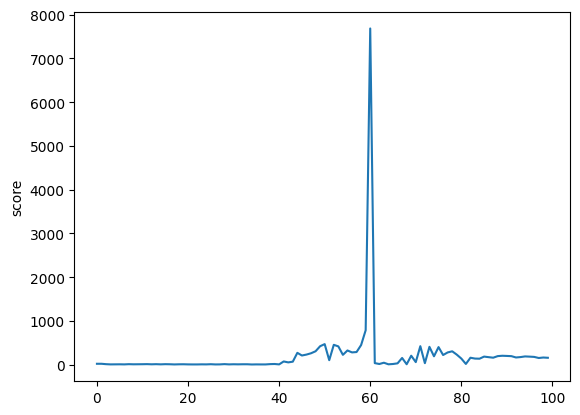

In [11]:
plt.plot(scores)
plt.ylabel('score')
plt.show()

## DQN with Target Network: Carte-Pole

0 episode finished after 38.00 rewards
1 episode finished after 10.00 rewards
2 episode finished after 10.00 rewards
3 episode finished after 60.00 rewards
4 episode finished after 19.00 rewards


C:\Users\user\AppData\Local\Temp\ipykernel_30392\3248349219.py:155: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  states = torch.Tensor(states).to(device)


5 episode finished after 34.00 rewards
6 episode finished after 10.00 rewards
7 episode finished after 9.00 rewards
8 episode finished after 8.00 rewards
9 episode finished after 12.00 rewards
10 episode finished after 13.00 rewards
11 episode finished after 10.00 rewards
12 episode finished after 13.00 rewards
13 episode finished after 13.00 rewards
14 episode finished after 12.00 rewards
15 episode finished after 11.00 rewards
16 episode finished after 11.00 rewards
17 episode finished after 13.00 rewards
18 episode finished after 12.00 rewards
19 episode finished after 11.00 rewards
20 episode finished after 10.00 rewards
21 episode finished after 15.00 rewards
22 episode finished after 35.00 rewards
23 episode finished after 23.00 rewards
24 episode finished after 34.00 rewards
25 episode finished after 42.00 rewards
26 episode finished after 57.00 rewards
27 episode finished after 42.00 rewards
28 episode finished after 31.00 rewards
29 episode finished after 65.00 rewards
30 epis

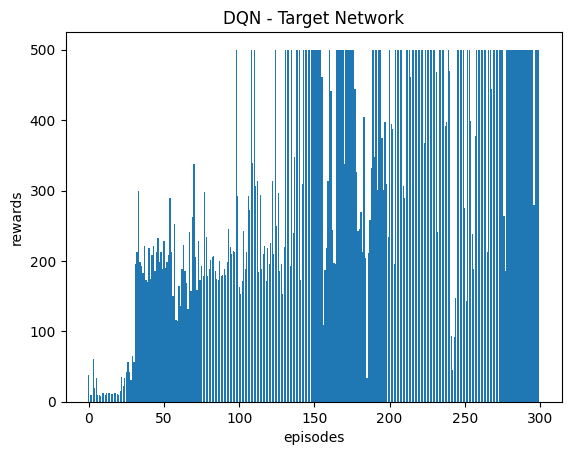

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import math
import random
import time
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib
import os
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# env_name = 'MountainCar-v0' 
env_name = 'CartPole-v1'

env = gym.make(env_name)

# 하이퍼파라미터 설정
num_episodes = 300
GAMMA = 0.99  # 감마 (discount factor)
learning_rate = 0.001  # 학습률
hidden_layer = 120  # 은닉층 노드 수
replay_memory_size = 50_000  # 리플레이 메모리 크기
batch_size = 128  # 배치 크기

e_start = 0.9  # 입실론 초기값
e_end = 0.05  # 입실론 최종값
e_decay = 200  # 입실론 감소율

target_nn_update_frequency = 10  # 타겟 네트워크 업데이트 주기
clip_error = False  # 오차 클리핑 여부

device = "cpu"

n_inputs = env.observation_space.shape[0]  # 입력 차원 수 (상태 수)
n_outputs = env.action_space.n  # 출력 차원 수 (액션 수)

# 리플레이 메모리 클래스
class ExperienceReplay:
    def __init__(self, capacity):
        self.capacity = capacity  # 리플레이 메모리의 최대 크기 설정
        self.memory = []  # 경험을 저장할 메모리 리스트 초기화
        self.position = 0  # 현재 저장 위치 초기화

    # 경험 추가 함수
    def push(self, state, action, new_state, reward, done):
        # 주어진 경험(transition)을 메모리에 추가
        transition = (state, action, new_state, reward, done)

        if self.position >= len(self.memory):
            # 메모리에 빈 공간이 있으면 경험 추가
            self.memory.append(transition)
        else:
            # 메모리가 가득 차면 오래된 경험을 덮어쓰기
            self.memory[self.position] = transition
            
        # 저장 위치를 다음으로 이동, 용량을 초과하면 처음으로 돌아감
        self.position = (self.position + 1) % self.capacity

    # 경험 샘플링 함수
    def sample(self, batch_size):
        # 메모리에서 주어진 배치 크기만큼 무작위로 샘플링하여 반환
        return zip(*random.sample(self.memory, batch_size))

    def __len__(self):
        # 현재 메모리에 저장된 경험의 수를 반환
        return len(self.memory)

# 신경망 클래스
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(n_inputs, hidden_layer)
        self.linear2 = nn.Linear(hidden_layer, hidden_layer//2)
        self.linear3 = nn.Linear(hidden_layer//2, n_outputs)

    # 순전파 함수
    def forward(self, x):
        a1 = torch.relu(self.linear1(x))
        a2 = torch.relu(self.linear2(a1))
        output = self.linear3(a2)
        return output

# 액션 선택 함수
def select_action(state, steps_done):
    # 입실론 값 계산
    e_threshold = e_end + (e_start - e_end) * \
        math.exp(-1. * steps_done/e_decay)

    if random.random() > e_threshold:
        # 입실론보다 큰 경우, Q 함수에 따라 행동 선택
        with torch.no_grad():
            state = torch.Tensor(state).to(device)   # 상태를 텐서로 변환하고 장치에 할당
            action_values = Q(state)   # Q 함수를 사용하여 각 행동의 가치 계산
            action = torch.argmax(action_values).item()   # 가장 높은 가치를 갖는 행동 선택
    else: 
        # 입실론보다 작은 경우, 무작위 행동 선택 (탐색)
        action = env.action_space.sample()

    return action

# 리플레이 메모리 초기화
memory = ExperienceReplay(replay_memory_size)

# 타겟 Q함수 초기화 (랜덤 가중치)
target_Q = NeuralNetwork().to(device)

# Q함수 초기화 (랜덤 가중치로 신경망 생성)
Q = NeuralNetwork().to(device)

# 손실 함수 설정 (평균 제곱 오차)
criterion = nn.MSELoss()

# 최적화 알고리즘 설정 (Adam 옵티마이저)
optimizer = optim.Adam(Q.parameters(), lr=learning_rate)

# 타겟 네트워크 업데이트 카운터 초기화
update_target_counter = 0
# 각 에피소드에서 얻은 보상을 저장할 리스트 초기화
reward_history = []
# 총 스텝 수 초기화
total_steps = 0
# 학습 시작 시간 기록
start_time = time.time()

# 에피소드 루프
for episode in range(num_episodes):
    if episode > num_episodes * 0.98:
        env = gym.make(env_name, render_mode="human")
    else:
        env = gym.make(env_name)

    s, _ = env.reset()
    reward = 0
    while True:
        total_steps += 1

        # 액션 선택
        a = select_action(s, total_steps)

        # 환경에서 액션 수행
        s_, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated
        reward += r

        # 리플레이 메모리에 경험 저장
        memory.push(s, a, s_, r, done)

        if len(memory) >= batch_size:
            # 리플레이 메모리에서 미니배치 샘플링
            states, actions, new_states, rewards, dones = memory.sample(
                batch_size)

            # 샘플링한 데이터를 텐서로 변환하여 장치에 할당
            states = torch.Tensor(states).to(device)
            actions = torch.LongTensor(actions).to(device)
            new_states = torch.Tensor(new_states).to(device)
            rewards = torch.Tensor([rewards]).to(device)
            dones = torch.Tensor(dones).to(device)
            
            # 타겟 Q 네트워크로부터 새로운 상태의 Q 값 계산
            new_action_values = target_Q(new_states).detach()

            # 타겟 값 계산
            y_target = rewards + \
                (1 - dones) * GAMMA * torch.max(new_action_values, 1)[0]
            # 예측 값 계산
            y_pred_pre = Q(states)
            y_pred = y_pred_pre.gather(1, actions.unsqueeze(1))
            
            # 손실 계산 및 역전파
            loss = criterion(y_pred.squeeze(), y_target.squeeze())
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            # 타겟 네트워크 업데이트
            if update_target_counter % target_nn_update_frequency == 0:
                target_Q.load_state_dict(Q.state_dict())

            update_target_counter += 1

        s = s_

        if done:
            reward_history.append(reward)
            print(f"{episode} episode finished after {reward:.2f} rewards")
            break

# 평균 보상 출력
print("Average rewards: %.2f" % (sum(reward_history)/num_episodes))

# 마지막 50 에피소드의 평균 보상 출력
print("Average of last 100 episodes: %.2f" % (sum(reward_history[-50:])/50))

# 하이퍼파라미터 정보 출력
print("---------------------- Hyper parameters --------------------------------------")
print(
    f"GAMMA:{GAMMA}, learning rate: {learning_rate}, hidden layer: {hidden_layer}")
print(f"replay_memory: {replay_memory_size}, batch size: {batch_size}")
print(f"epsilon_start: {e_start}, epsilon_end: {e_end}, " +
      f"epsilon_decay: {e_decay}")
print(
    f"update frequency: {target_nn_update_frequency}, clipping: {clip_error}")

# 경과 시간 출력
elapsed_time = time.time() - start_time
print(f"Time Elapsed : {elapsed_time//60} min {elapsed_time%60:.0} sec")

# 학습 과정의 보상 플롯
plt.bar(torch.arange(len(reward_history)).numpy(), reward_history)
plt.xlabel("episodes")
plt.ylabel("rewards")
plt.title("DQN - Target Network")
plt.show()
